In [8]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model 
from tensorflow.keras.applications import inception_v3, EfficientNetB7, EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import optimizers

DATASET_LOCATION = 'D:\\dataset256\\UECFOOD100_copy'
DATASET_LOCATION_VALIDATION = 'D:\\dataset256\\UECFOOD100_copy_validation'
DATASET_SIZE = 100
LABELS_FILE = 'category.txt'

In [2]:
labels = pd.read_csv(DATASET_LOCATION + '\\category.txt', sep='\t')
print(labels)

     id                     name
0     1                     rice
1     2             eels on rice
2     3                    pilaf
3     4  chicken-'n'-egg on rice
4     5      pork cutlet on rice
..  ...                      ...
95   96          dipping noodles
96   97                  hot dog
97   98             french fries
98   99               mixed rice
99  100            goya chanpuru

[100 rows x 2 columns]


In [3]:
import cv2, os

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, db_dir, batch_size, input_shape, num_classes, 
                 shuffle=True, labels_dir=LABELS_FILE, sep='\t'):
        # TODO your initialization
        # you might want to store the parameters into class variables
        self.root = db_dir
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.sep = sep
        # load the data from the root directory
        self.data, self.labels = self.get_data(db_dir)
        self.db_dir = db_dir
        self.names = self.get_labels(db_dir, labels_dir)
        self.indices = np.arange(len(self.data))
        self.on_epoch_end()

    def get_labels(self, root_dir, file):
        fi = os.path.join(root_dir, file)
        rez = {}
        with open(fi, 'r') as f:
            f.readline()
            for line in f.readlines():
                line = line.strip()
                el = line.split(self.sep)
                rez[el[0]] = " ".join(el[1:])
        return rez

    def get_data(self, root_dir):
        """"
        Loads the paths to the images and their corresponding labels from the database directory
        """
        # TODO your code here
        x = []
        y = []
        mp = {}
        for file in os.listdir(root_dir):
            dirr = os.path.join(root_dir, file)
            if os.path.isdir(dirr):
                for img in os.listdir(dirr):
                    if img.endswith("jpg"):
                        if os.path.join(dirr, img) in mp:
                            mp[os.path.join(dirr, img)].append(int(file) - 1)
                        else:
                            mp[os.path.join(dirr, img)] = [int(file) - 1]
        for k, v in mp.items():
            x.append(k)
            y.append(v)
        self.data = np.array(x)
        self.labels = self.to_categorical(np.array(y), num_classes=self.num_classes)
        return self.data, self.labels

    def to_categorical(self, arr, num_classes):
        rez = np.zeros((len(arr), num_classes), dtype=np.float)
        for index in range(len(arr)):
            for el in arr[index]:
                rez[index, el] = 1
        return rez

    def __len__(self):
        """
        Returns the number of batches per epoch: the total size of the dataset divided by the batch size
        """
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        """"
        Generates a batch of data
        """
        batch_indices = self.indices[index*self.batch_size : (index+1)*self.batch_size]
        x = []
        for ind in batch_indices:
            try:
                im = cv2.imread(self.data[ind])
                if im.shape != (224,224,3):
                    im = cv2.resize(im, (224,224))
                x.append(im)
            except Exception as e:
                print(self.data[ind])
                raise e
        batch_x = np.array(x).astype(np.float) # TODO load the image from batch_indices
        batch_y = np.array([self.labels[el] for el in batch_indices]) # TODO load the corresponding labels of the images you loaded
        # optionally you can use: batch_y = tf.keras.utils.to_categorical(batch_y, num_classes=self.num_classes)
        return batch_x, batch_y

    def on_epoch_end(self):
        """"
        Called at the end of each epoch
        """
        # if required, shuffle your data after each epoch
        self.indices = np.arange(len(self.data))
        if self.shuffle:
            # TODO shuffle data
            # you might find np.random.shuffle useful here
            np.random.shuffle(self.indices)


In [4]:
gen = DataGenerator(DATASET_LOCATION, 32, (224, 224, 3), DATASET_SIZE)
val_gen = DataGenerator(DATASET_LOCATION_VALIDATION, 32, (224, 224, 3), DATASET_SIZE)

In [3]:
data = os.walk(DATASET_LOCATION)
x = {}
for (dirpath, dirnames, filenames) in data:
    for file in filenames:
        if file.endswith('j  pg'):
            if file in x:
                x[file].append(int(dirpath.split('\\')[-1]))
            else:
                x[file] = [dirpath + "\\" + file, int(dirpath.split('\\')[-1])]
print(x[list(x.keys())[0]])

['D:\\dataset256\\UECFOOD100_copy\\1\\1.jpg', 1, 42]


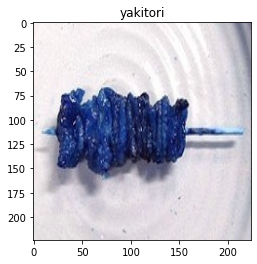

In [8]:
ims, lbls = gen[0]
imgplot = plt.imshow(ims[0].astype('uint8'), vmin=0, vmax=255)
plt.title(gen.names[str(np.argmax(lbls[0]) + 1)])
plt.show()

In [5]:
SHOULD_RESIZE = False
if SHOULD_RESIZE:
    for el in x.keys():
        ouput = cv2.resize(cv2.imread(x[el][0]), (224, 224))
        cv2.imwrite(x[el][0], ouput)
print("Number of images: ", len(x.keys()))
cats = 0
for el in x.keys():
    cats += len(x[el]) - 1
print("Number of classes per image: ", cats / len(x.keys()))

Number of images:  12740
Number of classes per image:  1.12723704866562


In [6]:
lista = []
lista_y = []
categs = []
counter = {}
for i in range(100):
    counter[i] = 90
for el in x.keys():
    if sum(counter.values()) == 0:
        break
    if x[el][1] in counter and counter[x[el][1]] > 0:
        lista.append(cv2.imread(x[el][0]))
        rez = []
        categs.append(x[el][1])
        for i in range(100):
            if i in x[el][1:]:
                rez.append(1)
            else:
                rez.append(0)
        lista_y.append(rez)
        counter[x[el][1]] -= 1
lista = np.array(lista)
lista_y = np.array(lista_y)

In [7]:
print(len(lista))
lista, val_lista, lista_y, val_lista_y = train_test_split(lista, lista_y, train_size=0.8)

8893


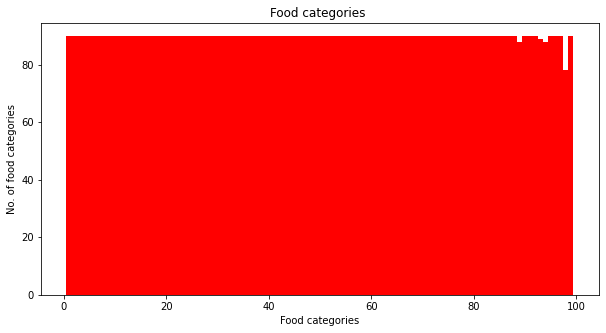

In [8]:
from collections import Counter
vals = Counter(categs)

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(vals.keys(), vals.values(), color ='red',
        width = 1)
 
plt.xlabel("Food categories")
plt.ylabel("No. of food categories")
plt.title("Food categories ")
plt.show()

In [14]:
base_model = inception_v3.InceptionV3(weights='imagenet', include_top=False)
base_model = EfficientNetB7(include_top = False, weights='imagenet')

# add a global spatial average pooling layer
x = base_model.output
base_model.trainable = False
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)

# and a logistic layer
predictions = Dense(DATASET_SIZE, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, None, None, 3 0           input_6[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, None, None, 3 7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization_2[0][0]            
____________________________________________________________________________________________

In [18]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(patience=2)

checkpointer = ModelCheckpoint(os.path.join('models', 'inceptionv3_' + 'multi-label' + '_best.h5'), verbose=1, save_best_only=True)

In [19]:
history = model.fit(gen, epochs=7, callbacks=[early_stopping, checkpointer], validation_data=val_gen)

Epoch 1/7
370/370 [==============================] - 3686s 10s/step - loss: 0.0481 - accuracy: 0.3507 - val_loss: 0.0450 - val_accuracy: 0.3822

Epoch 00001: val_loss improved from inf to 0.04499, saving model to models\inceptionv3_multi-label_best.h5


E:\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/7
370/370 [==============================] - 3616s 10s/step - loss: 0.0362 - accuracy: 0.4823 - val_loss: 0.0508 - val_accuracy: 0.3882

Epoch 00002: val_loss did not improve from 0.04499
Epoch 3/7
370/370 [==============================] - 3676s 10s/step - loss: 0.0354 - accuracy: 0.5219 - val_loss: 0.0548 - val_accuracy: 0.4006

Epoch 00003: val_loss did not improve from 0.04499


TypeError: cannot unpack non-iterable History object